In [55]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

output_directory = '/home/marco/DataspellProjects/thesis/output/pls/ST001937/'

df = pd.read_csv('../../data/ST001937_bm.csv')

palette = sns.color_palette(["#2176AB", "#F97662", "#FFBF00", "#50C878", "#B284BE"])
sns.set(style="whitegrid", font_scale=1.5)
sns.set_palette(palette)

In [56]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import roc_auc_score
import numpy as np

X = df.drop('Phenotypes', axis=1)
y = df['Phenotypes']

In [57]:
from sklearn.model_selection import StratifiedKFold

components = np.arange(1,15)
scores = []
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for i in components:
    kscores = []
    #10-fold cross validation
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        pls = PLSRegression(n_components=i)
        pls.fit(X_train, y_train)
        y_pred = pls.predict(X_test)
        kscores.append(roc_auc_score(y_test, y_pred))

    scores.append(kscores)

#getting scores distribution for each number of components
scores = np.array(scores)
score_mean = np.mean(scores, axis=1)
score_std = np.std(scores, axis=1)
score_25 = np.quantile(scores, 0.25, axis=1)
score_75 = np.quantile(scores, 0.75, axis=1)


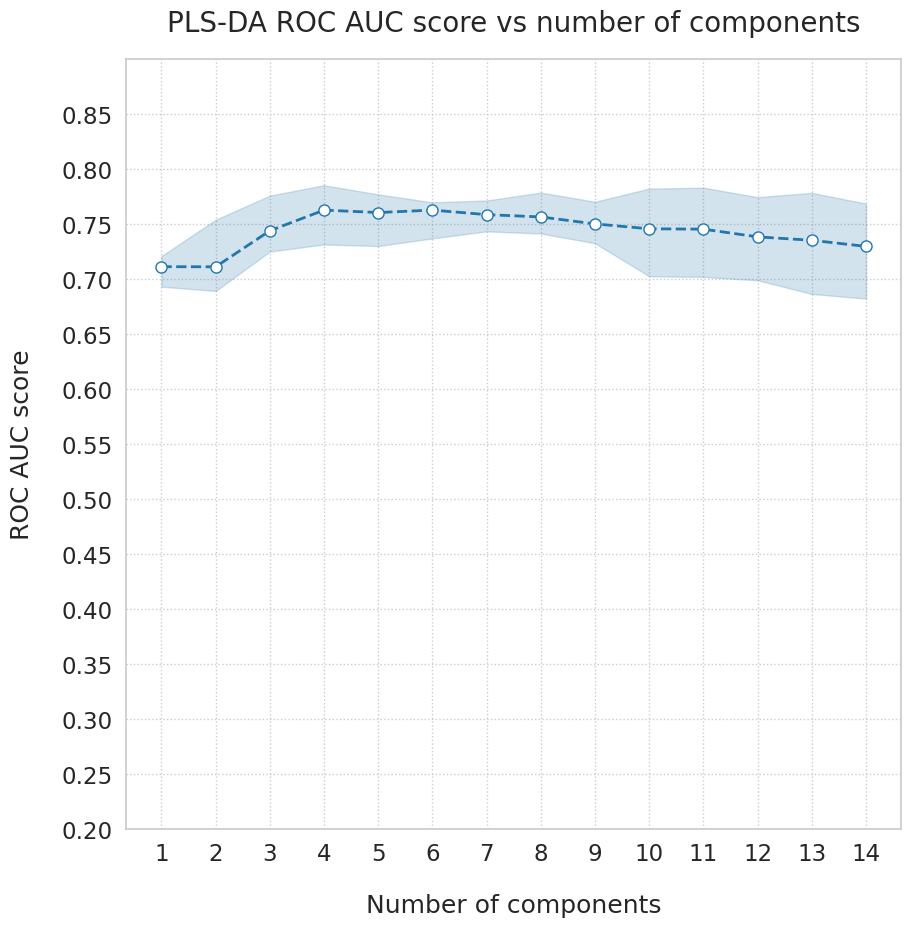

In [58]:
plt.figure(figsize=(10, 10))

# boxplot showing the distribution of the scores using line and markers
plt.plot(components, score_mean, color=palette[0], marker='o', markersize=8, linestyle='--', markeredgecolor=palette[0], markerfacecolor='white', linewidth=2)
plt.fill_between(components, score_25, score_75, color=palette[0], alpha=0.2)

# y axis limits
plt.ylim(0.2, 0.9)

# show plot grid
plt.xticks(components)
plt.yticks(np.arange(0.2, 0.9, 0.05))
plt.grid(True, linestyle=':', linewidth=1)
plt.xlabel('Number of components', labelpad=20)
plt.ylabel('ROC AUC score', labelpad=20)
plt.title('PLS-DA ROC AUC score vs number of components', fontsize=20, pad=20)
plt.savefig(output_directory + 'PLS-DA_number_of_components.png', dpi=300)


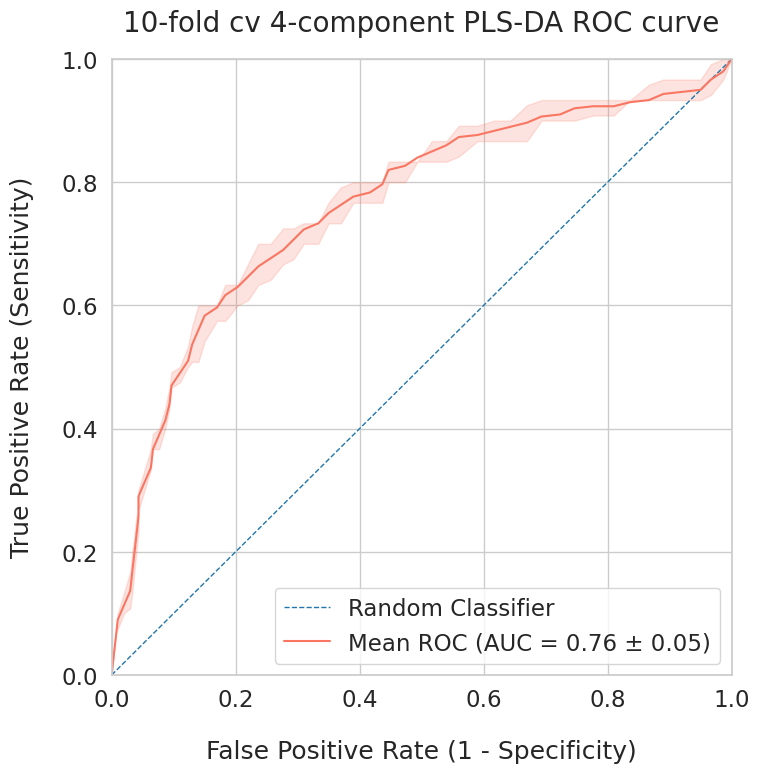

In [60]:
from sklearn.metrics import roc_curve, auc


roc_pls = PLSRegression(n_components=4)

roc_scores = dict()
roc_scores['fpr'] = []
roc_scores['tpr'] = []
roc_scores['roc_auc'] = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    roc_pls.fit(X_train, y_train)
    y_pred = roc_pls.predict(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred, drop_intermediate=False)
    roc_scores['fpr'].append(fpr)
    roc_scores['tpr'].append(tpr)
    roc_scores['roc_auc'].append(auc(fpr, tpr))

plt.figure(figsize=(8, 8))
# plotting the random line
plt.plot([0, 1], [0, 1], lw=1, linestyle='--', label='Random Classifier')

# Assicurati che tutte le liste di FPR e TPR abbiano la stessa lunghezza
max_length_fpr = min([len(lst) for lst in roc_scores['fpr']])
max_length_tpr = min([len(lst) for lst in roc_scores['tpr']])
roc_scores['fpr'] = [lst[:max_length_fpr] for lst in roc_scores['fpr']]
roc_scores['tpr'] = [lst[:max_length_tpr] for lst in roc_scores['tpr']]

# Calcola la media dei valori di FPR e TPR e l'AUC
mean_fpr = np.mean(roc_scores['fpr'], axis=0)
mean_tpr = np.mean(roc_scores['tpr'], axis=0)
mean_auc = np.mean(roc_scores['roc_auc'])

# Calcola 25 e 75 percentile
percentile_25_tpr = np.quantile(roc_scores['tpr'], 0.25, axis=0)
percentile_75_tpr = np.quantile(roc_scores['tpr'], 0.75, axis=0)

# Traccia la curva ROC media
plt.plot(mean_fpr, mean_tpr, label=f'Mean ROC (AUC = {mean_auc:.2f} ± {np.std(roc_scores["roc_auc"]):.2f})')
# Traccia la regione di deviazione standard
plt.fill_between(mean_fpr, percentile_25_tpr, percentile_75_tpr, color=palette[1], alpha=0.2)

# Personalizza il grafico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', labelpad=20)
plt.ylabel('True Positive Rate (Sensitivity)', labelpad=20)
plt.title('10-fold cv 4-component PLS-DA ROC curve', fontsize=20, pad=20)
plt.legend(loc='lower right')
plt.savefig(output_directory + 'PLS-DA_roc_curve.png', dpi=300, bbox_inches='tight')
